In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
import lime.lime_tabular
import lime.lime_tabular_mod
import matplotlib.pyplot as plt

import importlib
importlib.reload(lime.lime_tabular_mod)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
43,5.0,3.5,1.6,0.6,Iris-setosa
95,5.7,3.0,4.2,1.2,Iris-versicolor
134,6.1,2.6,5.6,1.4,Iris-virginica
127,6.1,3.0,4.9,1.8,Iris-virginica
39,5.1,3.4,1.5,0.2,Iris-setosa
...,...,...,...,...,...
88,5.6,3.0,4.1,1.3,Iris-versicolor
3,4.6,3.1,1.5,0.2,Iris-setosa
109,7.2,3.6,6.1,2.5,Iris-virginica
59,5.2,2.7,3.9,1.4,Iris-versicolor


### Prepare dataset 

In [3]:
labels_column_name = "label"
train_set = iris_dataset.drop(columns=labels_column_name).values
train_labels = iris_dataset[labels_column_name].values
jackknife_idx = np.random.randint(0, train_set.shape[0])
test_set = train_set[[jackknife_idx], :]
test_labels = train_labels[[jackknife_idx]]


unique_labels = np.unique(train_labels)
attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
unique_labels.sort()
attributes.sort()
print(f"Labels: {unique_labels}")
print(f"Attributes: {attributes}")

Labels: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Attributes: ['petal_length', 'petal_width', 'sepal_length', 'sepal_width']


In [4]:
random_forest = sklearn.ensemble.RandomForestClassifier(n_estimators = 42)
random_forest.fit(train_set, train_labels)

result = random_forest.predict(test_set)
accuracy = sklearn.metrics.accuracy_score(test_labels, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-versicolor']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime.lime_tabular_mod.LimeTabularExplainerMod(
    train_set,
    feature_names = attributes,
    class_names = train_labels
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
sample_idx = np.random.randint(low=0, high=test_set.shape[0])
instance = test_set[sample_idx]
probabilities = random_forest.predict_proba(instance.reshape(1,-1))[0,:]
probabilities_for_labels = {}
for label, probability in zip(random_forest.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 1.0, 'Iris-virginica': 0.0}


Explain the instance

array([0., 1., 0.])

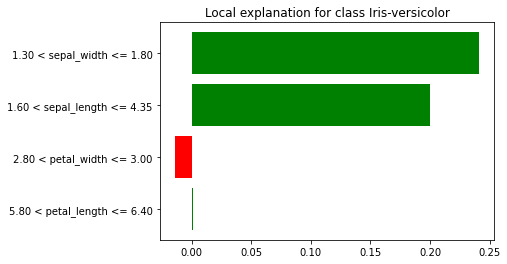

In [7]:
importlib.reload(lime.lime_tabular_mod)
explanation = explainer.explain_instance(
    instance,
    random_forest.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [8]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))


[0.0, 1.0, 0.0]
[0.06541213493250919, 0.7323863111977381, 0.20220155386975283]
[0.2442050296811179, 0.4757927376467463, 0.28000223267213603]


In [9]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(3, 0.24125096790570671),
 (2, 0.19997527940676826),
 (1, -0.014085669820467685),
 (0, 0.0013794805503220585)]

In [10]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(2, -0.15127468696436372),
 (1, 0.027155778232950952),
 (3, 0.023722196297775017),
 (0, 0.0015058166957036333)]

In [11]:
explanation.as_map()

{0: [(3, -0.2649731642034816),
  (2, -0.048700592442404565),
  (1, -0.01307010841248326),
  (0, -0.0028852972460256766)],
 2: [(2, -0.15127468696436372),
  (1, 0.027155778232950952),
  (3, 0.023722196297775017),
  (0, 0.0015058166957036333)],
 1: [(3, 0.24125096790570671),
  (2, 0.19997527940676826),
  (1, -0.014085669820467685),
  (0, 0.0013794805503220585)]}

In [12]:
explainer.discretizer.names

{0: ['petal_length <= 5.10',
  '5.10 < petal_length <= 5.80',
  '5.80 < petal_length <= 6.40',
  'petal_length > 6.40'],
 1: ['petal_width <= 2.80',
  '2.80 < petal_width <= 3.00',
  '3.00 < petal_width <= 3.30',
  'petal_width > 3.30'],
 2: ['sepal_length <= 1.60',
  '1.60 < sepal_length <= 4.35',
  '4.35 < sepal_length <= 5.10',
  'sepal_length > 5.10'],
 3: ['sepal_width <= 0.30',
  '0.30 < sepal_width <= 1.30',
  '1.30 < sepal_width <= 1.80',
  'sepal_width > 1.80']}

In [13]:
explainer.discretizer.maxs

{0: [5.1, 5.8, 6.4, 7.9],
 1: [2.8, 3.0, 3.3, 4.4],
 2: [1.6, 4.35, 5.1, 6.9],
 3: [0.3, 1.3, 1.8, 2.5]}

Update some attributes to see if probabilities would change

In [14]:
top_features = explanation.as_map()[predicted_label_id]
top_features

[(3, 0.24125096790570671),
 (2, 0.19997527940676826),
 (1, -0.014085669820467685),
 (0, 0.0013794805503220585)]

In [15]:
instance


array([5.9, 3. , 4.2, 1.5])